# Stanford CME 241 (Winter 2026) - Assignment 1

**Due: Friday, January 23 @ 11:59 PM PST on Gradescope.**

Assignment instructions:
- Make sure each of the subquestions have answers
- Ensure that group members indicate which problems they're in charge of
- Show work and walk through your thought process where applicable
- Empty code blocks are for your use, so feel free to create more under each section as needed
- Document code with light comments (i.e. 'this function handles visualization')

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):*

https://github.com/ward-benjamin/CME241_RL/blob/master/homeworks/assignment1.ipynb

*Group members (replace below names with people in your group):*
- Benjamin Ward

## Imports

In [3]:
import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))
sys.path.insert(0, str(Path("..").resolve()))

In [31]:
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Dict, Tuple

In [10]:
from rl.distribution import Categorical
from rl.markov_process import FiniteMarkovProcess, NonTerminal, Terminal

## Question 1: Snakes and Ladders (Led by Benjamin Ward)

In the classic childhood game of Snakes and Ladders, all players start to the left of square 1 (call this position 0) and roll a 6-sided die to represent the number of squares they can move forward. The goal is to reach square 100 as quickly as possible. Landing on the bottom rung of a ladder allows for an automatic free-pass to climb, e.g. square 4 sends you directly to 14; whereas landing on a snake's head forces one to slide all the way to the tail, e.g. square 34 sends you to 6. Note, this game can be viewed as a Markov Process, where the outcome is only depedent on the current state and not the prior trajectory. In this question, we will ask you to both formally describe the Markov Process that describes this game, followed by coding up a version of the game to get familiar with the RL-book libraries.


### Problem Statement

How can we model this problem with a Markov Process?

---

### Subquestions

#### Part (A): MDP Modeling

Formalize the state space of the Snakes and Ladders game. Don't forget to specify the terminal state!

---

#### Part (B): Transition Probabilities

Write out the structure of the transition probabilities. Feel free to abbreviate all squares that do not have a snake or ladder.

---

#### Part (C): Modeling the Game

Code up a `transition_map: Transition[S]` data structure to represent the transition probabilities of the Snakes and Ladders Markov Process so you can model the game as an instance of `FiniteMarkovProcess`. Use the `traces` method to create sampling traces, and plot the graph of the distribution of time steps to finish the game. Use the image provided for the locations of the snakes and ladders.

https://drive.google.com/file/d/1yhP242sG092Ico_WOPKrUp8jVJHbuGHH/view?usp=sharing

---

### Part (A) Answer
State space: S = {0,1,2,...,100} (we include 0 as the true "start" (before we're actually on the map))

Terminal state: T = {100}

### Part (B) Answer
There are 3 cases: either the state is the bottom rung of a ladder (case 1), either the state is the head of a snake (case 2), or the state is "normal" (case 3) (defined as not bottom of a ladder and not head of snake). Let's note x a given state. If x is bottom ladder, then top of ladder state is noted $l_x$, if x is head of snake, then tail of snake state is noted $s_x$.
- Case 1: then $\mathbb{P}(l_x\lvert x) = 1$
- Case 2: then $\mathbb{P}(s_x\lvert x) = 1$
- Case 3: let's note $D_x=\{\min(100,x+k), 1\leq k\leq 6\}$. Then $\forall t\in D_x \text{ with } t<100, \mathbb{P}[t\lvert x] = \frac{1}{6}$. If $100\in D_x$, $\mathbb{P}[100\lvert x] = \frac{7-\lvert D_x\lvert}{6}$

Note that we made an assumption here that if we go above 100, we also finish the game. This enables us to consider 100 as the unique terminal state. 

### Part (C) Answer

In [15]:
# fill in with Python code
jump = {
    1: 19, 4: 14, 8: 29, 21: 42, 28: 84, 51: 67, 71: 91, 80: 100,     # ladders
    97: 78, 95: 56, 88: 24, 62: 18, 48: 26, 36: 6, 32: 10     # snakes
}

In [16]:
def build_snakes_ladders_transition_map() -> dict[int, Categorical[int]]:
    transition_map: dict[int, Categorical[int]] = {}
    for s in range(0, 100):  # non terminal states
        probs = defaultdict(float)
        for k in range(1, 7):
            raw_spot = min(s + k, 100)       # clip at 100 (we consider "done" if above 100)
            # if we are at Case 1 (bottom ladder) or Case 2 (head snake) - it's a jump, else it's the right spot
            nxt_spot = jump.get(raw_spot, raw_spot)   
            probs[nxt_spot] += 1/6
        transition_map[s] = Categorical(dict(probs))
    return transition_map

def steps_to_terminal_100(trace) -> int:
    for t, st in enumerate(trace):
        if isinstance(st, Terminal) and st.state == 100:
            return t  # t steps from start
    return t  # fallback 

In [17]:
transition_map = build_snakes_ladders_transition_map()
markov_process = FiniteMarkovProcess(transition_map)

In [18]:
# We always start at state 0
start_dist = Categorical({NonTerminal(0): 1.0})
N_iter = 100000 # number of samples for average
finish_steps = []
for tr in markov_process.traces(start_dist):
    finish_steps.append(steps_to_terminal_100(tr))
    if len(finish_steps) >= N_iter:
        break

Minimum number of steps: 6


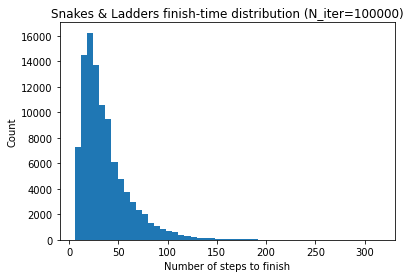

In [20]:
print(f'Minimum number of steps: {min(finish_steps)}')
plt.hist(finish_steps, bins=50)
plt.xlabel("Number of steps to finish")
plt.ylabel("Count")
plt.title(f"Snakes & Ladders finish-time distribution (N_iter={N_iter})")
plt.show()

$\textbf{Comment}$: as a sanity check, let's look at the minimum number of steps we found when we did the sampling. We found the minimum to be 6 steps. This is possible with the following sequence 0 to 4 (then jump to 14), 14 to 20, 20 to 26, 26 to 28 (jump to 76), 76 to 80 (jump to 99), 99 to 100.

## Question 2: Markov Decision Processes (Led by Benjamin Ward)

Consider an MDP with an infinite set of states ${S} = \{1,2,3,\ldots \}$. The start state is $s=1$. Each state $s$ allows a continuous set of actions $a \in [0,1]$. The transition probabilities are given by:
$$\mathbb{P}[s+1 \mid s, a] = a, \mathbb{P}[s \mid s, a] = 1 - a \text{ for all } s \in S \text{ for all } a \in [0,1]$$
For all states $s \in {S}$ and actions $a \in [0,1]$, transitioning from $s$ to $s+1$ results in a reward of $1-a$ and transitioning from $s$ to $s$ results in a reward of $1+a$. The discount factor $\gamma=0.5$.

### Problem Statement

How can we derive a mathematical formulation for the value function and the optimal policy? And how do those functions change when we modify the action space?

---

### Subquestions

#### Part (A): Optimal Value Function  

Using the MDP Bellman Optimality Equation, calculate the Optimal Value Function $V^*(s)$ for all $s \in {S}$. Given $V^*(s)$, what is the optimal action, $a^*$, that maximizes the optimal value function?

---

#### Part (B): Optimal Policy  

Calculate an Optimal Deterministic Policy $\pi^*(s)$ for all $s \in {S}$.

---

#### Part (C): Changing the Action Space  

Let's assume that we modify the action space such that instead of $a \in [0,1]$ for all states, we restrict the action space to $a \in \left[0,\frac{1}{s}\right]$ for state $s$. This means that higher states have more restricted action spaces. How does this constraint affect:

- The form of the Bellman optimality equation?
- The optimal value function, $V^*(s)$?
- The structure of the optimal policy, $\pi^*(s)$?

---

### Part (A) Answer
The MDP Bellman Optimality equation given in the slides is $V^*(s)=\max_{a\in A}\{R(s,a)+\gamma\sum_{s'\in N}\mathbb{P}(s,a,s')V^*(s')\}$.

We have $\gamma=0.5$, $A=[0,1]$, $R(s,a)=a(1-a)+(1-a)(1+a) = 1+a-2a^2$, $\mathbb{P}(s,a,s)=1-a$ and $\mathbb{P}(s,a,s+1)=a$. Plugging all of this in the above formula gives:
\begin{align}
V^*(s)=\max_{a\in [0,1]}\{1-a-2a^2+0.5[(1-a)V^*(s)+aV^*(s+1)]\}
\end{align}
We then note that since there is no terminal state, and our actions are only "stay" or "shift", then $V^*(s)$ is a constant, which we note $v$. Plugging this in:
\begin{align}
v &= \max_{a\in [0,1]}\{1-a-2a^2+0.5[(1-a)v+av]\} \\
\Rightarrow v &= 0.5v + \max_{a\in [0,1]}\{1-a-2a^2+0.5\} \\
\Rightarrow 0.5v &= \max_{a\in [0,1]}\{1.5-a-2a^2\} \\
\end{align}
Which reaches a maximum for $a=\frac{1}{4}$, giving $0.5v=1.5-0.25-0.125=1.125$, so $v=2.25$.

### Part (B) Answer
We just showed in part (a) that the optimal deterministic policy was to choose $a=0.25$ always. So using the required notations, this means $\forall s\in \mathbb{N}^*, \pi^*(s)=0.25$.

### Part (C) Answer

#### Bellman Optimality Equation Change:
We have only change the range of values $a$ can take (now we condition on s). So The Bellman Optimality Equation becomes:
\begin{align}
V^*(s)=\max_{a\in [0,1/s]}\{1-a-2a^2+0.5[(1-a)V^*(s)+aV^*(s+1)]\}
\end{align}

#### Optimal Value Function Change:
Previously due to the translation invariance and no terminal states, we were able to conclude that the optimal value function was a constant independent of the state. Now this is no longer the case, because the optimization space is dependent on the state. However since the set of actions $A_s=[0,1/s]$ is decreasing in $s$, we can get an intuition for what is happening. This means that we have that $V^*(s)$ is decreasing in $s$. To show this, consider one "player" at $s$, one player at $s+1$. We let the player at $s+1$ choose their policy. Then since $\forall t, A_t\subseteq A_{t+1}$, the player at $s$ can just replicate the policy of the player at $s+1$. If we assume that they have the uniform values $U\sim U[0,1]$ to decide the randomness, then we will always have the player which started at $s$ exactly one step behind the one who started at $s+1$. Since this holds for all policy that the player at $s+1$ could choose, we have $V^*(s)\leq V*(s+1)$ so $V^*$ is decreasing. 

#### Optimal Policy Change:
Since our Bellman Optimality Equation changed in such a way that we can't state that the value function is independent of the state and we can't calculate the explicit value of the value function which would have been needed to determine the optimal policy, we can no longer easily determine the fixed optimal policy. I was not able to analytically find the optimal policy.

## Question 3: Frog in a Pond (Led by Benjamin Ward)

Consider an array of $n+1$ lilypads on a pond, numbered $0$ to $n$. A frog sits on a lilypad other than the lilypads numbered $0$ or $n$. When on lilypad $i$ ($1 \leq i \leq n-1$), the frog can croak one of two sounds: **A** or **B**.

- If it croaks **A** when on lilypad $i$ ($1 \leq i \leq n-1$):
  - It is thrown to lilypad $i-1$ with probability $\frac{i}{n}$.
  - It is thrown to lilypad $i+1$ with probability $\frac{n-i}{n}$.
  
- If it croaks **B** when on lilypad $i$ ($1 \leq i \leq n-1$):
  - It is thrown to one of the lilypads $0, \ldots, i-1, i+1, \ldots, n$ with uniform probability $\frac{1}{n}$.

A snake, perched on lilypad $0$, will eat the frog if it lands on lilypad $0$. The frog can escape the pond (and hence, escape the snake!) if it lands on lilypad $n$.

### Problem Statement

What should the frog croak when on each of the lilypads $1, 2, \ldots, n-1$, in order to maximize the probability of escaping the pond (i.e., reaching lilypad $n$ before reaching lilypad $0$)?

Although there are multiple ways to solve this problem, we aim to solve it by modeling it as a **Markov Decision Process (MDP)** and identifying the **Optimal Policy**.

---

### Subquestions

#### Part (A): MDP Modeling

Express the frog-escape problem as an MDP using clear mathematical notation by defining the following components:

- **State Space**: Define the possible states of the MDP.
- **Action Space**: Specify the actions available to the frog at each state.
- **Transition Function**: Describe the probabilities of transitioning between states for each action.
- **Reward Function**: Specify the reward associated with the states and transitions.

---

#### Part (B): Python Implementation

There is starter code below to solve this problem programatically. Fill in each of the $6$ `TODO` areas in the code. As a reference for the transition probabilities and rewards, you can make use of the example in slide 16/31 from the following slide deck: https://github.com/coverdrive/technical-documents/blob/master/finance/cme241/Tour-MP.pdf.

Write Python code that:

- Models this MDP.
- Solves the **Optimal Value Function** and the **Optimal Policy**.

Feel free to use/adapt code from the textbook. Note, there are other libraries that are needed to actually run this code, so running it will not do anything. Just fill in the code so that it could run assuming that the other libraries are present.

---

#### Part (C): Visualization and Analysis

What patterns do you observe for the **Optimal Policy** as you vary $n$ from $3$ to $25$? When the frog is on lilypad $13$ (with $25$ total), what action should the frog take? Is this action different than the action the frog should take if it is on lilypad $1$?

---

### Part (A) Answer

#### State Space:  

State Space = {0,1,...n}, Terminal States ={0,n}

#### Action Space:  

Action Space = {A,B} (only applies to non-terminal states, we consider that are the terminal states there are no actions)

#### Transition Function:  

Case of "Croak A" (for $i\notin \{0,n\}$): $\mathbb{P}[i-1\lvert i,A] = \frac{i}{n}, \mathbb{P}[i+1\lvert i,A] = \frac{n-i}{n}$

Case of "Croak B" (for $i\notin \{0,n\}$): $\forall k\in [0,1,...,i-1,i+1,...,n]: \mathbb{P}[k\lvert i,B]=\frac{1}{n}$

For the terminal states: $\mathbb{P}[0\lvert 0,A]=\mathbb{P}[0\lvert 0,B]=1$ and $\mathbb{P}[n\lvert n,A]=\mathbb{P}[n\lvert n,B]=1$

#### Reward Function:  

We are "rewarded" if we escape i.e. reach $n$. So $R(n)=1$, and $\forall k\neq n, R(k)=0$.

### Part (B) Answer

In [69]:
MDPRefined = dict
def get_lily_pads_mdp(n: int) -> MDPRefined:
    data = {
        i: {
            'A': {
                i - 1: i/n, # TODO: fill in with the correct transition probabilities
                i + 1: (n-i)/n, # TODO: fill in with the correct transition probabilities
            },
            'B': {
                j: 1/n for j in range(n+1) if j!=i # TODO: fill in with the correct transition probabilities
            }
        } for i in range(1, n)
    }
    # If 0: eaten for sure, if n: saved for sure
    data[0] = {'A': {0: 1.0}, 'B': {0: 1.0}} # TODO: this is the initial state, so what would be the correct transition probabilities?
    data[n] = {'A': {n: 1.0}, 'B': {n: 1.0}} # TODO: similarly, this is the terminal state, so what would be the correct transition probabilities?

    gamma = 1.0
    # I tweaked the return to just return the data dictionary to solve the problem
    return data
    # return MDPRefined(data, gamma)

Mapping = dict
def direct_bellman(n: int) -> Mapping[int, float]:
    vf = [0.5] * (n + 1)
    vf[0] = 0.
    vf[n] = 0. 
    tol = 1e-8 # was 1e-8
    epsilon = tol * 1e4
    while epsilon >= tol:
        old_vf = [v for v in vf]
        for i in range(1, n):
            # Action A 
            # Probabilities
            p_left, p_right = i/n, (n-i)/n
            # Reward
            r_right = 1 if (i+1)==n else 0
            qA = p_left*old_vf[i-1]+p_right*(old_vf[i+1]+r_right)
            # Action B
            qB = 0
            for j in range(n+1):
                if j==i:
                    continue
                r = 1 if j==n else 0
                qB += (1/n)*(old_vf[j]+r)
            # Maximise
            vf[i] = max(qA,qB) # TODO: fill in with the Bellman update
        epsilon = max(abs(old_vf[i] - v) for i, v in enumerate(vf))
    return {v: f for v, f in enumerate(vf)}

In [70]:
res = direct_bellman(3)

In [71]:
res

{0: 0.0, 1: 0.5714285703926619, 2: 0.7142857111779859, 3: 0.0}

### Part (C) Answer

We find that whenever the frog is on lilypad 1, action B is preferred. In all other cases, action A is preferred. This makes intuitive sense. Action B creates a "risk of ruin" because there is a 1/n chance of ending on zero. Taking this risk is only worth it the frog is on lilypad 1. For example with n=25, we find that action B is preferred for lilypad 1, but for lilypad 13, action A is preferred.

In [76]:
def greedy_optimal_policy(n: int, vf_map: Dict[int, float]) -> Dict[int, str]:
    vf = [vf_map[i] for i in range(n + 1)]
    policy = {}
    for i in range(1, n):
        # Action A 
        # Probabilities
        p_left, p_right = i/n, (n-i)/n
        # Reward
        r_right = 1 if (i+1)==n else 0
        qA = p_left*vf[i-1]+p_right*(vf[i+1]+r_right)
        # Action B
        qB = 0
        for j in range(n+1):
            if j==i:
                continue
            r = 1 if j==n else 0
            qB += (1/n)*(vf[j]+r)
        policy[i] = 'A' if qA >= qB else 'B'
    return policy

def solve_frog_escape(n: int) -> Tuple[Dict[int, float], Dict[int, str]]:
    # Optimal value function
    vf = direct_bellman(n) 
    # Optimal policy
    pi = greedy_optimal_policy(n, vf) 
    return vf, pi

In [78]:
vf25, pi25 = solve_frog_escape(25)
print("Optimal action at lilypad 13 (n=25):", pi25[13])
print("Optimal action at lilypad 1  (n=25):", pi25[1])

Optimal action at lilypad 13 (n=25): A
Optimal action at lilypad 1  (n=25): B


In [ ]:
policies = {}
for n in [3,5,10,15]:
    _, pi = solve_frog_escape(n)
    policies[n] = pi
    print(f"Policy for {n}: {policies[n]}")

Policy for 3: {1: 'B', 2: 'A'}
Policy for 5: {1: 'B', 2: 'A', 3: 'A', 4: 'A'}
Policy for 10: {1: 'B', 2: 'A', 3: 'A', 4: 'A', 5: 'A', 6: 'A', 7: 'A', 8: 'A', 9: 'A'}
Policy for 15: {1: 'B', 2: 'A', 3: 'A', 4: 'A', 5: 'A', 6: 'A', 7: 'A', 8: 'A', 9: 'A', 10: 'A', 11: 'A', 12: 'A', 13: 'A', 14: 'A'}


## Question 4: Manual Value Iteration (Led by Benjamin Ward)

Consider a simple MDP with ${S} = \{s_1, s_2, s_3\}, {T} = \{s_3\}, {A} = \{a_1, a_2\}$. The State Transition Probability function  
$${P}: {N} \times {A} \times {S} \rightarrow [0, 1]$$  
is defined as:  
$${P}(s_1, a_1, s_1) = 0.25, {P}(s_1, a_1, s_2) = 0.65, {P}(s_1, a_1, s_3) = 0.1$$  
$${P}(s_1, a_2, s_1) = 0.1, {P}(s_1, a_2, s_2) = 0.4, {P}(s_1, a_2, s_3) = 0.5$$  
$${P}(s_2, a_1, s_1) = 0.3, {P}(s_2, a_1, s_2) = 0.15, {P}(s_2, a_1, s_3) = 0.55$$  
$${P}(s_2, a_2, s_1) = 0.25, {P}(s_2, a_2, s_2) = 0.55, {P}(s_2, a_2, s_3) = 0.2$$  

The Reward Function  
$${R}: {N} \times {A} \rightarrow \mathbb{R}$$  
is defined as:  
$${R}(s_1, a_1) = 8.0, {R}(s_1, a_2) = 10.0$$  
$${R}(s_2, a_1) = 1.0, {R}(s_2, a_2) = -1.0$$  

Assume a discount factor of $\gamma = 1$.

### Problem Statement

Your task is to determine an Optimal Deterministic Policy **by manually working out** (not with code) the first two iterations of the Value Iteration algorithm.

---

### Subquestions

#### Part (A): 2 Iterations

1. Initialize the Value Function for each state to be its $\max$ (over actions) reward, i.e., we initialize the Value Function to be $v_0(s_1) = 10.0, v_0(s_2) = 1.0, v_0(s_3) = 0.0$. Then manually calculate $q_k(\cdot, \cdot)$ and $v_k(\cdot)$ from $v_{k - 1}(\cdot)$ using the Value Iteration update, and then calculate the greedy policy $\pi_k(\cdot)$ from $q_k(\cdot, \cdot)$ for $k = 1$ and $k = 2$ (hence, 2 iterations).

---

#### Part (B): Argument

1. Now argue that $\pi_k(s_1)$ for $k > 2$ will be the same as $\pi_2(s_1)$. *Hint*: You can make the argument by examining the structure of how you get $q_k(\cdot, \cdot)$ from $v_{k-1}(\cdot)$. With this argument, there is no need to go beyond the two iterations you performed above, and so you can establish $\pi_2(\cdot)$ as an Optimal Deterministic Policy for this MDP.

---

#### Part (C): Policy Evaluation

1. Using the policy $\pi_2(\cdot)$, compute the exact value function $V^{\pi_2}(s)$ for all $s\in S$.

---

#### Part (D): Sensitivity Analysis

Assume the reward for $R(s_1, a_2)$ is modified to $11.0$ instead of $10.0$.

1. Perform one iteration of Value Iteration starting from the initialized value function $v_0(s)$, where $v_0(s)$ remains the same as in the original problem.
2. (IGNORE THIS) Determine whether this change impacts the Optimal Deterministic Policy $\pi(\cdot)$. If it does, explain why.

---

### Part (A) Answer

We know that (for a discount factor of 1):
\begin{align}
q_k(s,a) &= R(s,a)+\sum_{s'}P(s,a,s')v_{k-1}(s') \\
v_k(s)&=\max_a q_k(s,a)
\end{align}
Plugging in the numerical values given with an initialization of $v_0(s_1)=10$, $v_0(s_2)=0$ and $v_0(s_3)=0$ gives:
\begin{align}
q_1(s_1,a_1) &= 8.0 + 0.25*10 + 0.65*1 + 0.1*0 = 11.15 \\
q_1(s_2,a_1) &= 1.0 + 0.3*10 + 0.15*1 + 0.55*0 = 4.15 \\
q_1(s_1,a_2) &= 10.0 + 0.1*10 + 0.4*1 + 0.5*0 = 11.4 \\
q_1(s_2,a_2) &= -1.0 + 0.25*10 + 0.55*1 + 0.2*0 = 2.05\\
\end{align}
So maximizing over actions gives:
\begin{align}
v_1(s_1) &= 11.4 \\
v_1(s_2) &= 4.15 \\
v_1(s_3) &= 0 \\
\end{align}
Therefore we have the greedy policy:
\begin{align}
\pi_1(s_1) &= a_2 \text{ since 11.4>11.15} \\
\pi_1(s_2) &= a_1 \text{ since 4.15>2.05}
\end{align}
Let's now move forward to k=2, same procedure:
\begin{align}
q_2(s_1,a_1) &= 8.0 + 0.25*11.4 + 0.65*4.15 + 0.1*0 = 13.5475 \\
q_2(s_2,a_1) &= 1.0 + 0.3*11.4 + 0.15*4.15 + 0.55*0 = 5.0425  \\
q_2(s_1,a_2) &= 10.0 + 0.1*11.4 + 0.4*4.15 + 0.5*0 = 12.80 \\
q_2(s_2,a_2) &= -1.0 + 0.25*11.4 + 0.55*4.15 + 0.2*0 = 4.1325 \\
\end{align}
So maximizing over actions gives:
\begin{align}
v_2(s_1) &=  13.5475 \\
v_2(s_2) &=  5.0425\\
v_2(s_3) &=  0 \\
\end{align}
Therefore we have the greedy policy:
\begin{align}
\pi_2(s_1) &= a_1 \text{ since 13.5475>12.80} \\
\pi_2(s_2) &= a_1 \text{ since 5.0425>4.1325}
\end{align}

### Part (B) Answer:  

Let's prove that for all $k\geq 2$, the $\pi_k(s_1)=\pi_2(s_1)=a_1$.
We compute:
\begin{align}
\Delta_k = q_k(s_1,a_1)-q_k(s_1,a_2) &= R(s_1,a_1)+\sum_{s'}P(s_1,a_2,s')v_{k-1}(s') - R(s_1,a_2)+\sum_{s'}P(s,a_2,s')v_{k-1}(s') \\
&= [R(s_1,a_1)-R(s_1,a_2)] + \sum_{s'}[P(s_1,a_2,s')-P(s_1,a_2,s')]v_{k-1}(s') \\
&= [8-10] + (0.25-0.1)v_{k-1}(s_1)+ (0.65-0.4)v_{k-1}(s_2) + (0.1-0.5)v_{k-1}(s_3) \\
&= -2 + 0.15*v_{k-1}(s_1) + 0.25*v_{k-1}(s_2) + 0 
\end{align}
In particular, since $\pi_2(s_1)=a_1$, this means $\Delta_2>0$.

We now use the monotonicity property of the Bellman operator (slide 19/36), which gives that if $v_k(s_i)\leq v_{k+1}(s_i)$. 

In particular, applied to $s_1,s_2$, this means that $v_k(s_1)<=v_{k+1}(s_1), v_k(s_2)<=v_{k+1}(s_2)$. 

Now note that $\Delta_k=-2 + 0.15*v_k(s_1) + 0.25*v_k(s_2)$, so $\Delta_k$ is an increasing function of $v_{k-1}(s_1)$ and of $v_k{k-1}(s_2)$, so $\Delta_k\geq \Delta_{k-1}$, so $\Delta_k$ is an increasing function of k. 

Since $\Delta_2>0$, we have $\forall k\geq 2, \Delta_k>=\Delta_2>0$ i.e. $q_k(s_1,a_1)>q_k(s_1,a_2)$, so $\pi_k(s_1)=a_1$, which is what we wanted to prove.


### Part (C) Answer:  

Let's calculate the value function using $\pi_2$.  We showed that $\pi_2(s_1)=a_1$, $\pi_2(s_2)=a_1$, and since $s_3$ is terminal, $V^{\pi_2}(s_3)=0$. Using $\gamma=1$ in the Bellman equation gives:
\begin{align}
V^{\pi_2}(s_1) &= R(s_1,a_1)+\sum_{s'}P(s_1,a_1,s')V^{\pi_2}(s') \\
&= 8+0.25V^{\pi_2}(s_1)+0.65V^{\pi_2}(s_2) \\
\Rightarrow 0.75V^{\pi_2}(s_1)- 0.65V^{\pi_2}(s_2) &= 8 \\
V^{\pi_2}(s_2) &= R(s_2,a_1)+\sum_{s'}P(s_2,a_1,s')V^{\pi_2}(s') \\
&= 1+0.3V^{\pi_2}(s_1)+0.15V^{\pi_2}(s_2) \\
\Rightarrow -0.3V^{\pi_2}(s_1)+ 0.85V^{\pi_2}(s_2) &= 1
\end{align}
So we need to solve the 2 equation 2 unknown system:
\begin{align}
0.75V^{\pi_2}(s_1)- 0.65V^{\pi_2}(s_2) &= 8 \\
-0.3V^{\pi_2}(s_1)+ 0.85V^{\pi_2}(s_2) &= 1
\end{align}
Which gives $V^{\pi_2}(s_1)=\frac{2980}{177}\approx 16.84$ and $V^{\pi_2}(s_2)=\frac{420}{50}\approx 7.12$.

### Part (D) Answer

#### Value Iteration:  

We now assume the reward for $R(s_1, a_2)$ is modified to $11.0$ instead of $10.0$. We do one value-iteration loop.
\begin{align}
q_1(s_1,a_1) &= 8.0 + 0.25*10 + 0.65*1 + 0.1*0 = 11.15 \\
q_1(s_2,a_1) &= 1.0 + 0.3*10 + 0.15*1 + 0.55*0 = 4.15 \\
q_1(s_1,a_2) &= 11.0 + 0.1*10 + 0.4*1 + 0.5*0 = 12.4 \\
q_1(s_2,a_2) &= -1.0 + 0.25*10 + 0.55*1 + 0.2*0 = 2.05\\
\end{align}
So maximizing over actions gives:
\begin{align}
v_1(s_1) &= 12.4 \\
v_1(s_2) &= 4.15 \\
v_1(s_3) &= 0 \\
\end{align}
Therefore we have the (same as before) greedy policy:
\begin{align}
\pi_1(s_1) &= a_2 \text{ since 12.4>11.15} \\
\pi_1(s_2) &= a_1 \text{ since 4.15>2.05}
\end{align}

#### Optimal Deterministic Policy:  

(IGNORED FOLLOWING ED POST)

## Question 5: Fixed-Point and Policy Evaluation True/False Questions (Led by Benjamin Ward)

### Recall Section: Key Formulas and Definitions

#### Bellman Optimality Equation
The Bellman Optimality Equation for state-value functions is:
$$
V^*(s) = \max_a \left[ R(s, a) + \gamma \sum_{s'} P(s, a, s') V^*(s') \right].
$$
For action-value functions:
$$
Q^*(s, a) = R(s, a) + \gamma \sum_{s'} P(s, a, s') \max_{a'} Q^*(s', a').
$$

#### Contraction Property
The Bellman Policy Operator $B^\pi$ is a contraction under the $L^\infty$-norm:
$$
\|B^\pi(X) - B^\pi(Y)\|_\infty \leq \gamma \|X - Y\|_\infty.
$$
This guarantees convergence to a unique fixed point.

#### Policy Iteration
Policy Iteration alternates between:
1. **Policy Evaluation**: Compute $V^\pi$ for the current policy $\pi$.
2. **Policy Improvement**: Generate a new policy $\pi'$ by setting:
   $$
   \pi'(s) = \arg\max_a \left[ R(s, a) + \gamma \sum_{s'} P(s, a, s') V^\pi(s') \right].
   $$

#### Discounted Return
The discounted return from time step $t$ is:
$$
G_t = \sum_{i=t+1}^\infty \gamma^{i-t-1} R_i,
$$
where $\gamma \in [0, 1)$ is the discount factor.

### True/False Questions (Provide Justification)

1. **True/False**: If $Q^\pi(s, a) = 5$, $P(s, a, s') = 0.5$ for $s' \in \{s_1, s_2\}$, and the immediate reward $R(s, a)$ increases by $2$, the updated action-value function $Q^\pi(s, a)$ also increases by $2$.


---

2. **True/False**: For a discount factor $\gamma = 0.9$, the discounted return for rewards $R_1 = 5, R_2 = 3, R_3 = 1$ is greater than $6$.

---

3. **True/False**: The Bellman Policy Operator $B^\pi(V) = R^\pi + \gamma P^\pi \cdot V$ satisfies the contraction property for all $\gamma \in [0, 1)$, ensuring a unique fixed point.

---

4. **True/False**: In Policy Iteration, the Policy Improvement step guarantees that the updated policy $\pi'$ will always perform strictly better than the previous policy $\pi$.

---

5. **True/False**: If $Q^\pi(s, a) = 10$ for all actions $a$ in a state $s$, then the corresponding state-value function $V^\pi(s) = 10$, regardless of the policy $\pi$.

---

6. **True/False**: The discounted return $G_t = \sum_{i=t+1}^\infty \gamma^{i-t-1} R_i$ converges to a finite value for any sequence of bounded rewards if $\gamma < 1$.

---

### Answers (Provide justification, brief explanations are fine)

#### Question 1:  

<span style="color:red">*fill in*</span>

#### Question 2:  

<span style="color:red">*fill in*</span>

#### Question 3:  

<span style="color:red">*fill in*</span>

#### Question 4:  

<span style="color:red">*fill in*</span>

#### Question 5:  

<span style="color:red">*fill in*</span>

#### Question 6:  

<span style="color:red">*fill in*</span>